In [526]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)
import seaborn as sns

<h3>NOTES</h3> <br>
<ul>
    <li>It seems like very small MSEs can still make huge prediction differences ...</li>
    <li>"This may also be a result of the broad model scale; perhaps models with a smaller spatial extent or more rich spatial would perform better in these areas, as they would not perform complete pooling of the estimated effects across a large heterogeneous region".</li>
    <li>The MSE is very fluctuating, and depends heavily on how the data was split into test and training. It does seem so that once the data is split, differen models will have similar ranges of MSEs even tho they train using stochastic mini batch gradient descent. </li>
    <li>Storm order would count as what the paper called "derived explanatory variables"</li>
    <li>We took out the outlier of 1.2 billion</li>
</ul>

<h1>Thunderstorms in Texas with income and storm order</h1>

In [613]:
# load top 500 thunderstorms in texas from 1950 - 2018
data = pd.read_csv("texas_thunderstorm.csv", usecols=[1, 2, 3, 4, 6, 7, 10, 11, 29, 30, 31, 32, 33])
data.info()

data = data.sample(frac=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 13 columns):
CZ_NAME_STR            352 non-null object
BEGIN_LOCATION         352 non-null object
BEGIN_DATE             352 non-null object
BEGIN_TIME             352 non-null int64
MAGNITUDE              352 non-null float64
STORM_ORDER            352 non-null int64
DAMAGE_PROPERTY_NUM    352 non-null int64
DAMAGE_CROPS_NUM       352 non-null int64
END_LOCATION           352 non-null object
BEGIN_LAT              352 non-null float64
BEGIN_LON              352 non-null float64
END_LAT                352 non-null float64
END_LON                352 non-null float64
dtypes: float64(5), int64(4), object(4)
memory usage: 35.8+ KB


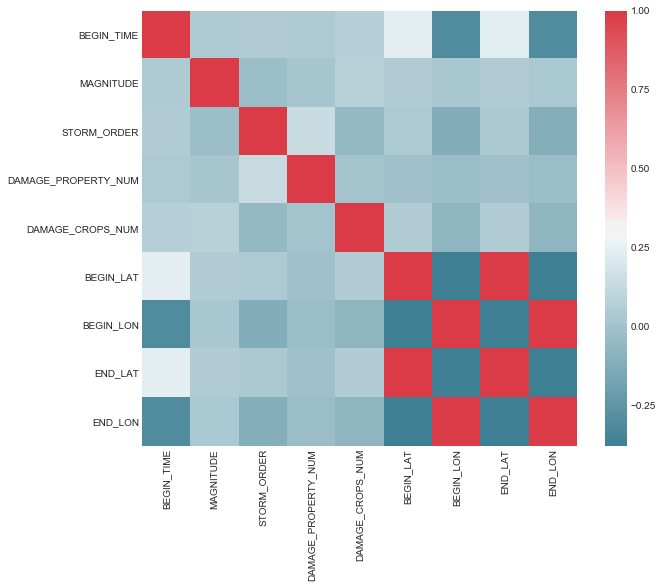

In [614]:
# names = ['CZ_NAME_STR','BEGIN_LOCATION','BEGIN_DATE','BEGIN_TIME','MAGNITUDE','DAMAGE_PROPERTY_NUM','DAMAGE_CROPS_NUM','END_LOCATION','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']
corr = data.corr()
# plot correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [529]:
# The outcomes
thunderstorm_outcomes = data.iloc[:, [6]]

list(thunderstorm_outcomes)
thunderstorm_outcomes

,DAMAGE_PROPERTY_NUM
116,200000
254,750000
253,200000
301,3000000
148,10000000
80,3000000
121,500000
294,350000
38,250000
147,500000


In [585]:
# The predictors
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)

# NOTE: for right now crops damage is included, but we may want to see both with and without including this

list(thunderstorm_predictors)

['BEGIN_TIME',
 'MAGNITUDE',
 'STORM_ORDER',
 'DAMAGE_CROPS_NUM',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON']

In [586]:
texas_income_data = pd.read_csv("MACHINE_LEARNING_DATA/county_year/texas_median_county_income_all.csv")
texas_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 2 columns):
name        3302 non-null object
estimate    3301 non-null float64
dtypes: float64(1), object(1)
memory usage: 51.7+ KB


In [587]:
# Add column to input features
# 1990, 2000, 2009 forward 
def parse_date(year):
    if int(year) < 95:
        return '1990'
    elif int(year) >= 95 or int(year) < 5:
        return '2000'
    elif int(year) >= 5 and int(year) < 9:
        return '2009'
    elif int(year) >= 9:
        return '20' + year
    
def add_mean_income(thunderstorm_predictors):
    thunderstorm_predictors['MEAN_INCOME'] = 100
    years = [date.split('/')[-1] for date in data['BEGIN_DATE']]
    years = [parse_date(year) for year in years]
    estimates = []
    for i in range(len(thunderstorm_predictors)):
        keyword = data['CZ_NAME_STR'][i] + years[i]
        estimate = texas_income_data[texas_income_data['name'] == keyword].values[0][1]
        estimates.append(estimate)
    thunderstorm_predictors['MEAN_INCOME'] = estimates

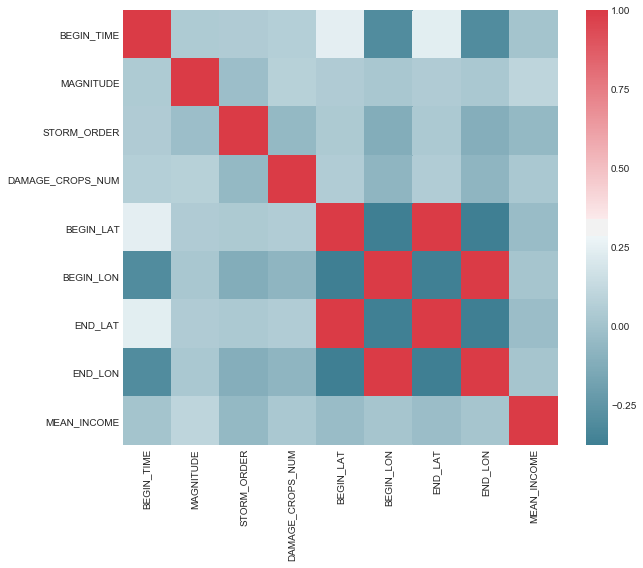

In [615]:
add_mean_income(thunderstorm_predictors)
# names = ['CZ_NAME_STR','BEGIN_LOCATION','BEGIN_DATE','BEGIN_TIME','MAGNITUDE','DAMAGE_PROPERTY_NUM','DAMAGE_CROPS_NUM','END_LOCATION','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']
corr = thunderstorm_predictors.corr()
# plot correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [589]:
def preprocess(thunderstorm_outcomes, thunderstorm_predictors):
    # Make the outcomes into a numpy array
    outcome_array = thunderstorm_outcomes.values.astype(np.float)
    
    # log scale
    outcome_array = np.log(outcome_array + 1)

    # split into test and training data
    split_index = int(0.8 * len(outcome_array))
    outcome_array_train = outcome_array[:split_index, :]
    outcome_array_test = outcome_array[split_index:, :]
    print(outcome_array_train.shape)
    print('Shape of outcome array training', outcome_array_train.shape)
    print('Shape of outcome array test', outcome_array_test.shape)
    
    # normalize outcome
    outcome_array_train = (outcome_array_train - np.mean(outcome_array))/np.std(outcome_array)
    outcome_array_test = (outcome_array_test - np.mean(outcome_array))/np.std(outcome_array)
    
    outcome_mean_log = np.mean(outcome_array)
    outcome_std_log = np.std(outcome_array)

    # Make that numpy array into a torch Tensor
    outcome_Tensor_train = torch.from_numpy(outcome_array_train)
    outcome_Tensor_test = torch.from_numpy(outcome_array_test)

    # Make the predictors into a numpy array
    predictors_array = thunderstorm_predictors.values
    # NOTE: we took out any missing data values in the csv 

    # split into test and training data
    predictors_array_train = predictors_array[:split_index, :]
    predictors_array_test = predictors_array[split_index:, :]
    print('Shape of inputs array training', predictors_array_train.shape)
    print('Shape of inputs array test', predictors_array_test.shape)

    # Normalize inputs
    predictors_array_train = (predictors_array_train - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)
    predictors_array_test = (predictors_array_test - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)

    # Make that numpy array into a torch Tensor
    predictors_Tensor_train = torch.from_numpy(predictors_array_train.astype(np.float))
    predictors_Tensor_test = torch.from_numpy(predictors_array_test.astype(np.float))

    # Convert those DoubleTensors to FloatTensors
    # Chaning outcomes from a DoubleTensor to a FloatTensor
    outcome_Tensor_train = outcome_Tensor_train.float()
    outcome_Tensor_test = outcome_Tensor_test.float()

    # Changing the predictors too
    predictors_Tensor_train = predictors_Tensor_train.float()
    predictors_Tensor_test = predictors_Tensor_test.float()
    
    return (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,
            outcome_Tensor_test, outcome_mean_log, outcome_std_log)

(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean_log, outcome_std_log) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)


<h1>One hidden layer</h1>

In [590]:
class one_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(one_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)
    
# Make it
one_hidden_model = one_hidden_Net()

In [591]:
# Define the loss function
loss_fn = torch.nn.MSELoss(size_average = False)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [592]:
def train_neural_net(model, train_outcomes, train_inputs, test_outcomes, test_inputs):
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_test_loss_value = []
    
    # Set the optimizer
    # originally step size was 1e-2
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    # Train the neural network
    # 100000 iterations seems to give much better results when networks is two layers deep
    for t in range(20000):
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_inputs))[0:50]
        
        # Get the current mini-batches
        predictors_mini = train_inputs[indices]
        outcome_mini = train_outcomes[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        test_pred = model(test_inputs)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data.item())
        
        current_test_loss = loss_fn(test_pred, test_outcomes)
        current_test_loss_value.append(current_test_loss.data.item())
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
        
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_test = (np.asarray(current_test_loss_value) / len(test_inputs)).tolist()
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_test, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

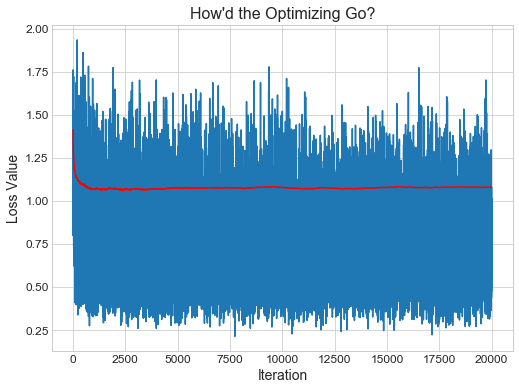

In [593]:
train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train, 
                 outcome_Tensor_test, predictors_Tensor_test)

In [594]:
def plot_train_perf(train_predictors, train_obs, model):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictors.requires_grad = False
    train_predictions = model(train_predictors)
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*outcome_std_log + outcome_mean_log).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*outcome_std_log + outcome_mean_log).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

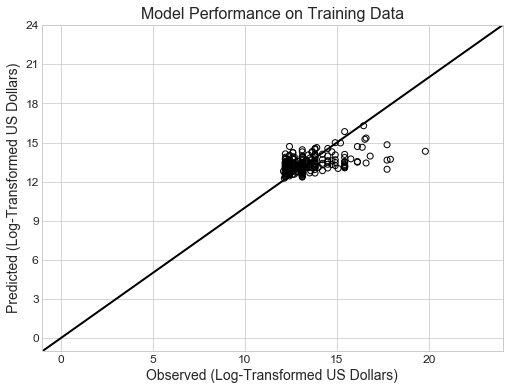

In [595]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, one_hidden_model)

In [596]:
def compute_MSE(predictors, observed_outcomes, model):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    predictors.requires_grad = False
    predictions = model(predictors)
    
    # Get the validation set outcomes
    outcomes = observed_outcomes
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(predictions, outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [597]:
one_hidden_MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)
one_hidden_MSE

tensor(1.0820, grad_fn=<DivBackward0>)

In [543]:
def display_readable_predictions(predictors, observed_outcomes, model):
    predictions = np.exp((model(predictors) * outcome_std_log + outcome_mean_log).detach().numpy()) - 1
    
    observed = np.exp(observed_outcomes * outcome_std_log + outcome_mean_log) - 1
    
    for i in range(len(predictions)):
        print((predictions[i][0].item(), observed[i][0].item()))
        print(predictions[i][0].item() - observed[i][0].item())
    

In [544]:
display_readable_predictions(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)

(458522.84375, 199999.984375)
258522.859375
(707851.3125, 1500000.75)
-792149.4375
(1311584.375, 199999.984375)
1111584.390625
(2075015.75, 210000.0)
1865015.75
(692724.5, 2000000.375)
-1307275.875
(512080.59375, 300000.1875)
212080.40625
(435607.40625, 199999.984375)
235607.421875
(388559.0625, 275000.09375)
113558.96875
(678322.5, 500000.28125)
178322.21875
(454693.03125, 7000002.5)
-6545309.46875
(384548.21875, 250000.0)
134548.21875
(572779.5, 9999996.0)
-9427216.5
(372492.28125, 250000.0)
122492.28125
(383440.0625, 199999.984375)
183440.078125
(667030.8125, 250000.0)
417030.8125
(469065.28125, 1500000.75)
-1030935.46875
(636822.1875, 350000.15625)
286822.03125
(412445.59375, 199999.984375)
212445.609375
(469861.3125, 9999996.0)
-9530134.6875
(466407.59375, 250000.0)
216407.59375
(537623.5625, 1000000.125)
-462376.5625
(626934.1875, 2000000.375)
-1373066.1875
(2571509.5, 400000.03125)
2171509.46875
(490395.78125, 300000.1875)
190395.59375
(450857.78125, 250000.0)
200857.78125
(3785

<h2>Two hidden layers</h2>

In [545]:
class two_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(two_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 4)
        self.fc3 = torch.nn.Linear(4, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)
    
# Make it
two_hidden_model = two_hidden_Net()

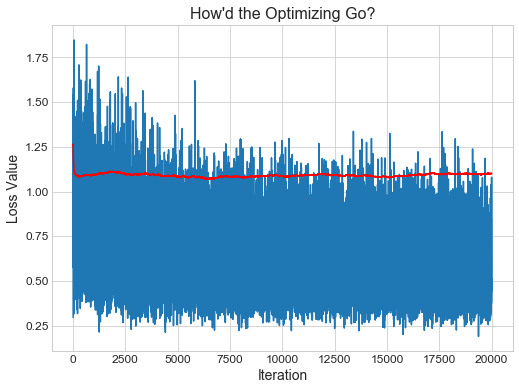

In [546]:
train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

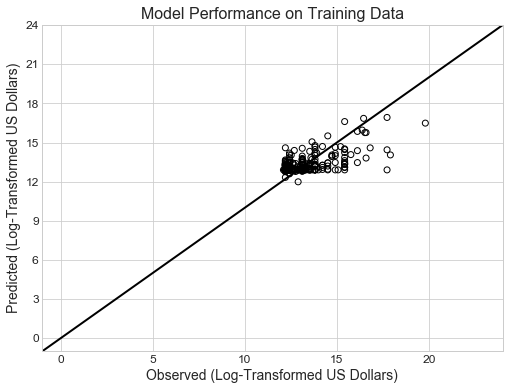

In [547]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, two_hidden_model)

In [548]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)
MSE

tensor(1.1007, grad_fn=<DivBackward0>)

In [549]:
display_readable_predictions(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)

(559623.6875, 199999.984375)
359623.703125
(1568145.125, 1500000.75)
68144.375
(932886.9375, 199999.984375)
732886.953125
(1437827.0, 210000.0)
1227827.0
(772088.8125, 2000000.375)
-1227911.5625
(402600.15625, 300000.1875)
102599.96875
(402600.15625, 199999.984375)
202600.171875
(402600.15625, 275000.09375)
127600.0625
(402600.15625, 500000.28125)
-97400.125
(517517.34375, 7000002.5)
-6482485.15625
(402600.15625, 250000.0)
152600.15625
(921182.625, 9999996.0)
-9078813.375
(402600.15625, 250000.0)
152600.15625
(402600.15625, 199999.984375)
202600.171875
(402600.15625, 250000.0)
152600.15625
(402600.15625, 1500000.75)
-1097400.59375
(641620.375, 350000.15625)
291620.21875
(402600.15625, 199999.984375)
202600.171875
(402600.15625, 9999996.0)
-9597395.84375
(402600.15625, 250000.0)
152600.15625
(1751340.5, 1000000.125)
751340.375
(602756.3125, 2000000.375)
-1397244.0625
(6483242.5, 400000.03125)
6083242.46875
(2264575.5, 300000.1875)
1964575.3125
(528296.0, 250000.0)
278296.0
(429961.65625

<h2>Feature importance evaluation</h2>

In [598]:
class leave_out_Net(torch.nn.Module):
    def __init__(self):
        super(leave_out_Net, self).__init__()
        self.fc1 = torch.nn.Linear(8, 5)
        self.fc2 = torch.nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

<h3>Leave out BEGIN_TIME</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0456171035766602

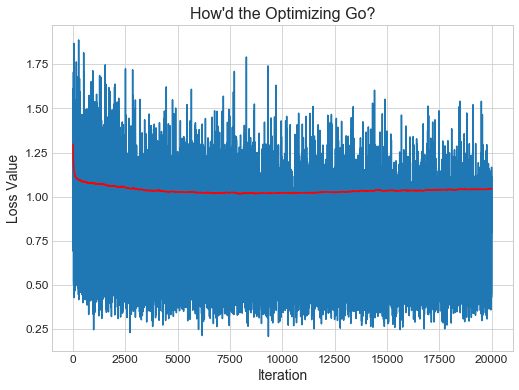

In [599]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'BEGIN_TIME'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_time_model = leave_out_Net()

# Train one layer
train_neural_net(without_time_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_time_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out DAMAGE_CROPS_NUM</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


0.9643511772155762

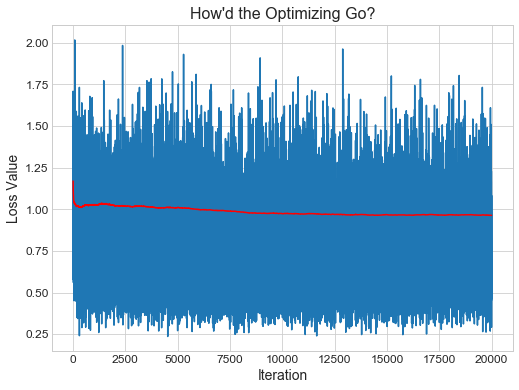

In [600]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'DAMAGE_CROPS_NUM'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_damage_crops_model = leave_out_Net()

# Train one layer
train_neural_net(without_damage_crops_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_damage_crops_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out STORM_ORDER</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.062511920928955

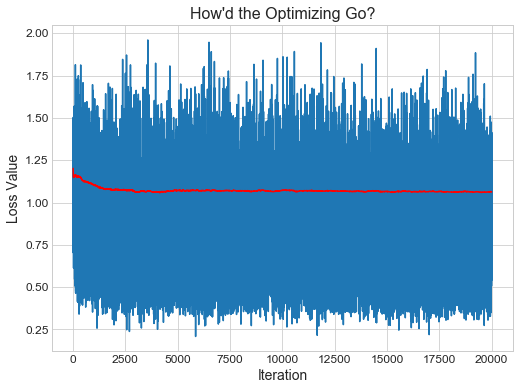

In [601]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'STORM_ORDER'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_storm_order_model = leave_out_Net()

# Train one layer
train_neural_net(without_storm_order_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_storm_order_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out MAGNITUDE</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.1245125532150269

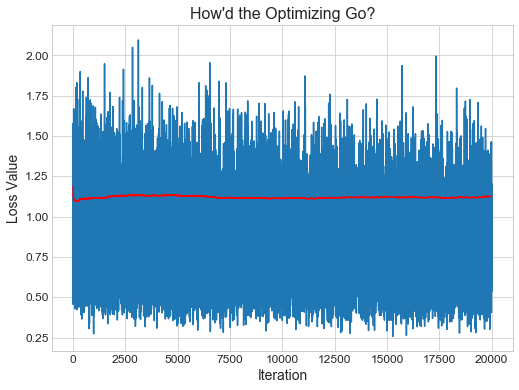

In [602]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'MAGNITUDE'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_magnitude_model = leave_out_Net()

# Train one layer
train_neural_net(without_magnitude_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_magnitude_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out BEGIN_LAT</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0464245080947876

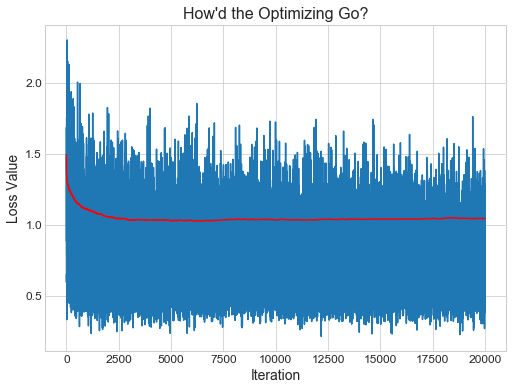

In [603]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'BEGIN_LAT'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_begin_lat_model = leave_out_Net()

# Train one layer
train_neural_net(without_begin_lat_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_begin_lat_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out BEGIN_LON</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.1291857957839966

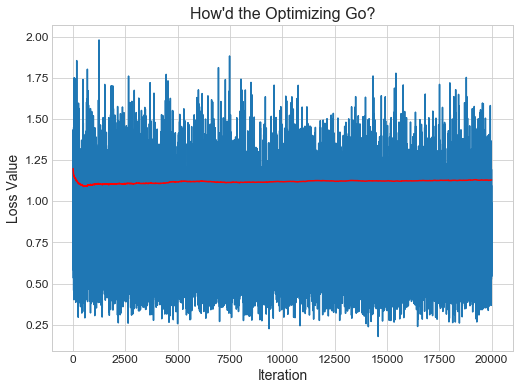

In [604]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'BEGIN_LON'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_begin_lon_model = leave_out_Net()

# Train one layer
train_neural_net(without_begin_lon_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_begin_lon_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out END_LAT</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0543808937072754

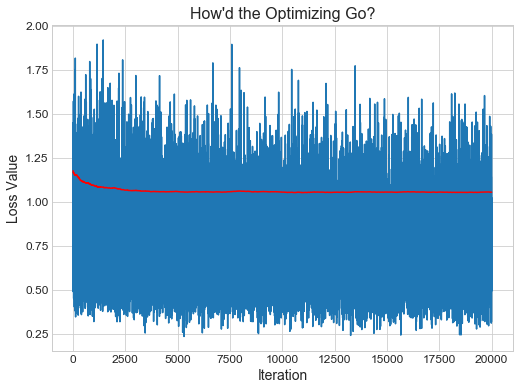

In [605]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'END_LAT'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_end_lat_model = leave_out_Net()

# Train one layer
train_neural_net(without_end_lat_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_end_lat_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out END_LON</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0689170360565186

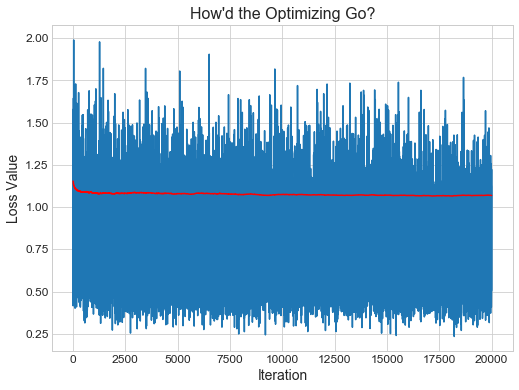

In [606]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'END_LON'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_end_lon_model = leave_out_Net()

# Train one layer
train_neural_net(without_end_lon_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_end_lon_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out MEAN_INCOME</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


0.9976235032081604

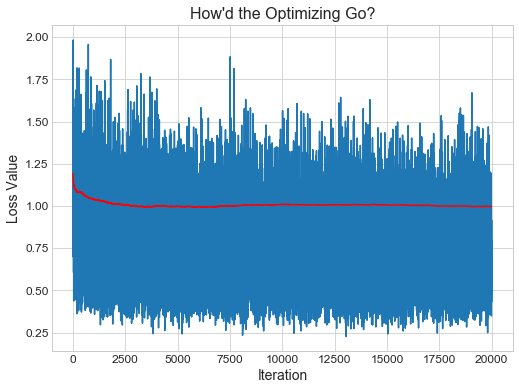

In [607]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)
# add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_income_model = leave_out_Net()

# Train one layer
train_neural_net(without_income_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_income_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

Since the MSE is only changing very slightly, we dare not make any hard conclusions about exactly which features are highly impacting the predictions of our model. 

<h2>Finding the best model over 100 iterations</h2>
Since in the beginning, our MSE was varying wildly, we trained the one and two layer models 100 times and stored the minimum MSE. This way we have some measure of how good we can train our model given that we train it many times. 

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array tr

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array tr

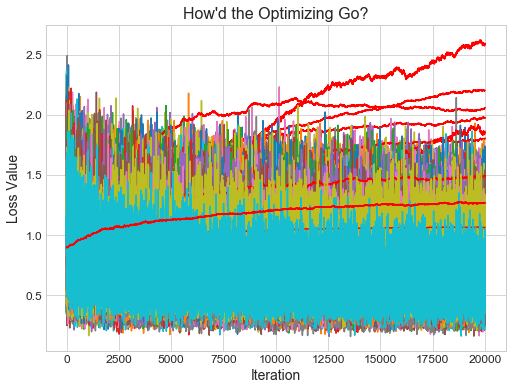

In [609]:
best_model = None
best_mse = 10
for i in range(100):
    data = data.sample(frac=1)
    thunderstorm_outcomes = data.iloc[:, [6]]
    thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)
    add_mean_income(thunderstorm_predictors)
    (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)
    
    # define our nets
    one_hidden_model = one_hidden_Net()
    two_hidden_model = two_hidden_Net()
    
    # Train one layer
    train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    # Train two layer
    train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    
    one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model).item()
    two_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model).item()
    
    if (one_layer_mse < best_mse):
        best_model = one_hidden_model
        best_mse = one_layer_mse
    if (two_layer_mse < best_mse):
        best_model = two_hidden_model
        best_mse = two_layer_mse
        
print(best_model)
print(best_mse)

From training the one hidden layer model and two hidden layer model 100 times on random training and test splits of the data, the best MSE we can achieve is 0.535. We can see from the results above that the two hidden layer model is more prone to overfitting. 

In [610]:
print(best_model)

one_hidden_Net(
  (fc1): Linear(in_features=9, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)
